# Predicción de Exitus (fallecimiento) con XGBoost

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("../datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596,21,0,1,151,Q,1,0
1,4,0.306931,20973,22,0,1,99,Q,1,0
2,4,0.278481,19611,19,0,1,87,Q,1,0
3,3,0.150289,13583,22,0,1,100,Q,1,0
4,1,0.016573,18042,2,0,1,44,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4.

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD.
        
- **edad_dias**: Edad en días del paciente.

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas.
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso.
    
- **proc**: Procedencia del paciente.

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial.

- **tipgrd**: GRD médico (M) o de quirófano (Q).
    
- **tiping**: Tipo de ingreso: Programado, urgente...
    
- **exitus**: 1 = El paciente falleció.

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

## Pre-procesado

### One-Hot Encoding

Utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [4]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [5]:
print(categorical_vars)
print(numerical_vars)

['tiping', 'gravedad', 'tipgrd', 'proc']
['edad_dias', 'exitus', 'numproc', 'pct_mortalidad_norma', 'estancia_esperada', 'potencial_ambul']


Realizamos one hot encoding de las variables categoricas

In [6]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Visualizamos los datos iniciales y los que están con one hot encoding para ver la diferencia

In [7]:
X[categorical_vars].head()

,tiping,gravedad,tipgrd,proc
0,1,4,Q,1
1,1,4,Q,1
2,1,4,Q,1
3,1,3,Q,1
4,1,1,Q,1


In [8]:
X_ohe.head()

,"(x0_1,)","(x0_2,)","(x0_3,)","(x1_1,)","(x1_2,)","(x1_3,)","(x1_4,)","(x2_M,)","(x2_Q,)","(x3_1,)","(x3_2,)","(x3_3,)","(x3_4,)","(x3_6,)","(x3_7,)","(x3_8,)","(x3_9,)"
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Volvemos a pegar las variables numéricas.

In [9]:
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [10]:
y = X['exitus']
del X['exitus']

In [11]:
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

    (x0_1,)  (x0_2,)   (x0_3,)   (x1_1,)   (x1_2,)   (x1_3,)   (x1_4,)  \
0  0.589285  -0.5681 -0.118114 -1.322185 -0.435743 -0.417921  4.120705   
1  0.589285  -0.5681 -0.118114 -1.322185 -0.435743 -0.417921  4.120705   
2  0.589285  -0.5681 -0.118114 -1.322185 -0.435743 -0.417921  4.120705   
3  0.589285  -0.5681 -0.118114 -1.322185 -0.435743  2.392797 -0.242677   
4  0.589285  -0.5681 -0.118114  0.756324 -0.435743 -0.417921 -0.242677   

    (x2_M,)   (x2_Q,)   (x3_1,)  ...   (x3_6,)   (x3_7,)   (x3_8,)   (x3_9,)  \
0 -1.554964  1.554964  0.589002  ... -0.118114 -0.009578 -0.134718 -0.090724   
1 -1.554964  1.554964  0.589002  ... -0.118114 -0.009578 -0.134718 -0.090724   
2 -1.554964  1.554964  0.589002  ... -0.118114 -0.009578 -0.134718 -0.090724   
3 -1.554964  1.554964  0.589002  ... -0.118114 -0.009578 -0.134718 -0.090724   
4 -1.554964  1.554964  0.589002  ... -0.118114 -0.009578 -0.134718 -0.090724   

      index  edad_dias   numproc  pct_mortalidad_norma  estancia_esperada 

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [12]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [13]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [14]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 23)
Train target size = (22894,)
Validation data size = (4905, 23)
Validation target size = (4905,)
Test data size = (4907, 23)
Test target size = (4907,)



## XGBoost

Vamos a aplicar ahora un modelo de XGBoost para intentar predecir la probabilidad de exitus en función de todas las otras variables de las que disponemos en el dataset. Recordemos que la definición de Gradient Boosting es la siguiente:

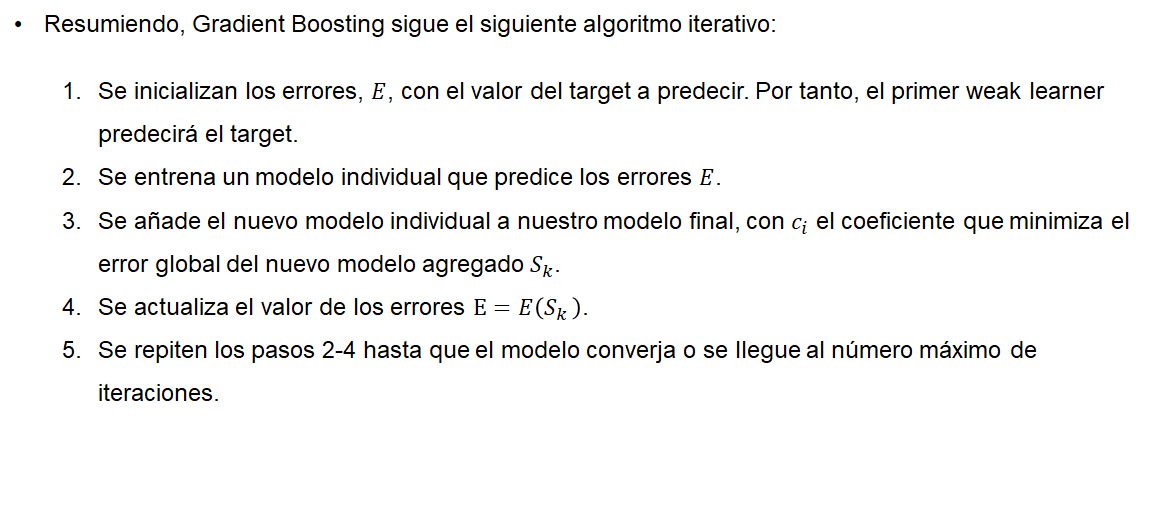


1) Importar modelo.

En este caso tenemos que irnos **fuera de scikit-learn** para aplicar modelos XGBoost.


In [28]:
from xgboost import XGBClassifier

Veamos su documentación.

In [29]:
?XGBClassifier

2) Importar métrica.

In [27]:
from sklearn.metrics import roc_auc_score as auc

3) Definir el método.

Vamos a entrenar un modelo con parámetros por defecto

In [20]:
model = XGBClassifier(random_state = 1)

4) Llamar al método fit para entrenar el modelo. **Utilizaremos early stopping**

In [21]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.92503
[1]	validation_0-auc:0.91893
[2]	validation_0-auc:0.92020
[3]	validation_0-auc:0.92484
[4]	validation_0-auc:0.92759
[5]	validation_0-auc:0.92179
[6]	validation_0-auc:0.90473
[7]	validation_0-auc:0.91601
[8]	validation_0-auc:0.92099
[9]	validation_0-auc:0.92376
[10]	validation_0-auc:0.92253
[11]	validation_0-auc:0.92452


C:\Users\Usuario\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.92615
[13]	validation_0-auc:0.92695
[14]	validation_0-auc:0.92588


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

5) Llamar al método predict para generar las predicciones.

In [22]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [23]:
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_77632\934495496.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


In [37]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.959265,0.927589,0.916104


Vamos a comprobar si XGBoost devuelve probabilidades calibradas.

In [24]:
from sklearn.calibration import calibration_curve
?calibration_curve

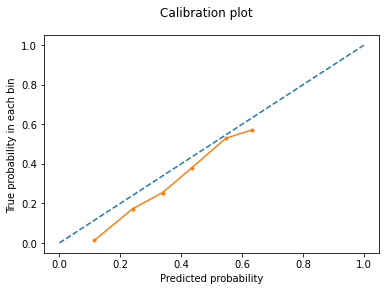

In [25]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
no_zeros = fop > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]
no_zeros = mpv > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]

fig, ax = plt.subplots()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.show()

También se puede medir con el brier score.

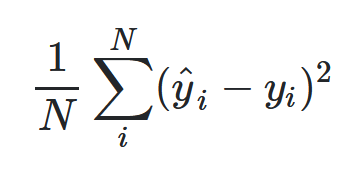

Donde:

- $y_i$ es el target a predecir (0 o 1).
- $\hat{y}_i$ es la probabilidad predicha de pertenecer a la clase 1, $P(y_i = 1)$.

In [26]:
from sklearn.metrics import brier_score_loss

In [372]:
?brier_score_loss

In [373]:
brier_score_loss(y_test, pred_test_p[:, 1])

0.040034629592967906

Las probabilidades parecen calibradas, sino lo están podemos usar:

In [355]:
?CalibratedClassifierCV

Atentos al comentario sobre **cv = "prefit"**.

# Grid Search


Vamos a proceder a calcular los parámetros óptimos para nuestro modelo. En nuestro caso queremos optimizar todos los hiperparámetros que hemos visto en clase:

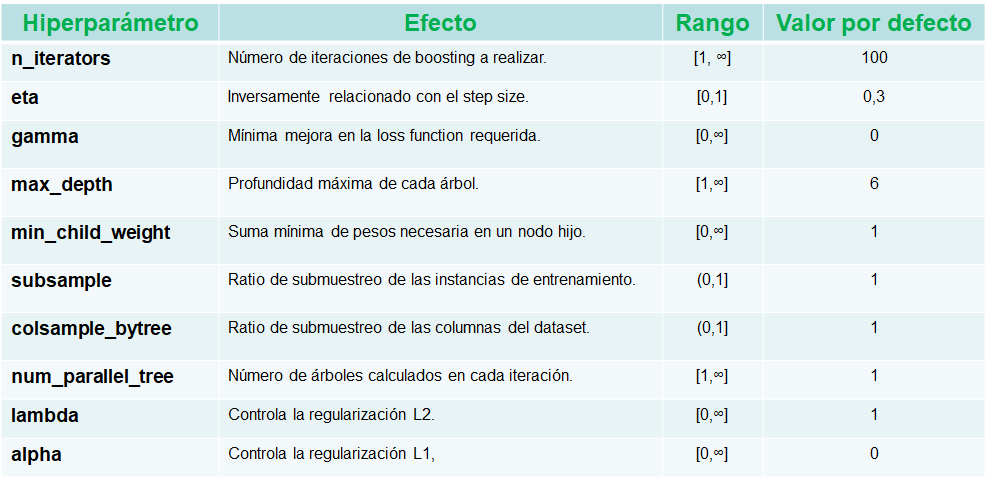

Para establecer nthread detectaremos automáticamente el número de CPUs en nuestro sistema y dejaremos uno libre. Para ello usaremos la función multiprocessing.cpu_count()

In [25]:
help(multiprocessing.cpu_count)

Help on method cpu_count in module multiprocessing.context:

cpu_count() method of multiprocessing.context.DefaultContext instance
    Returns the number of CPUs in the system



In [27]:
nthread = multiprocessing.cpu_count() - 1;
print(nthread);

11


Podemos ayudar a nuestro modelo XGBoost indicando el ratio entre casos negativos y positivos.

In [17]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(scale_pos_weight)

24.868926553672317


XGBoost lleva a cabo computaciones con componente **aleatorio** (por ejemplo, al hacer subsample), por lo que es muy importante que nos aseguremos de controlar la semilla aleatorio que empleamos para poder replicar el modelo que evaluamos en validación en caso de ser elegido como el modelo final.

In [18]:
random_state = 1;

Definimos el grid a llevar a cabo

In [19]:
nrounds_values = [2, 10]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

params_values = {'nrounds': nrounds_values,
             'eta': eta_values,
             'gamma': gamma_values,
             'max_depth': max_depth_values,
             'min_child_weight': min_child_weight_values,
             'subsample': subsample_values,
             'colsample_bytree': colsample_bytree_values,
             'num_parallel_tree': num_parallel_tree_values,
             'lambda': lambda_values,
             'alpha': alpha_values}

num_iteraciones = len(params_values['nrounds']) * len(params_values['eta']) * len(params_values['gamma']) * len(params_values['max_depth']) * \
len(params_values['min_child_weight']) * len(params_values['subsample']) * len(params_values['colsample_bytree']) * \
len(params_values['num_parallel_tree']) * len(params_values['lambda']) * len(params_values['alpha'])

print('El numero de iteraciones es', num_iteraciones)

El numero de iteraciones es 1024


In [21]:
grid_results = pd.DataFrame();
num_iter = 0
for nrounds in params_values['nrounds']:
    for eta in params_values['eta']:
        for gamma in params_values['gamma']:
            for max_depth in params_values['max_depth']:
                for min_child_weight in params_values['min_child_weight']:
                    for subsample in params_values['subsample']:
                        for colsample_bytree in params_values['colsample_bytree']:
                            for num_parallel_tree in params_values['num_parallel_tree']:
                                for lamda in params_values['lambda']:
                                    for alpha in params_values['alpha']:

                                        # print control iteracion modelo
                                        print('Inicio de iteracion ' + str(num_iter) + 
                                              '. Parametro n_estimators = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '\n')
                                        # Entrenar modelo
                                        model = XGBClassifier(random_state = random_state,
                                                              n_estimators = nrounds,
                                                              learning_rate = eta, 
                                                              gamma = gamma,
                                                              max_depth = max_depth,
                                                              min_child_weight = min_child_weight ,
                                                              subsample = subsample,
                                                              colsample_bytree = colsample_bytree,
                                                              num_parallel_tree = num_parallel_tree,
                                                              reg_lambda = lamda,
                                                              reg_alpha = alpha)
                                        model.fit(X_train, np.array(y_train))

                                        # Generar predicciones
                                        pred_train_p = model.predict_proba(X_train)
                                        pred_val_p = model.predict_proba(X_val)

                                        # Calcular métricas de evaluación
                                        auc_train = auc(y_train, pred_train_p[:, 1])
                                        auc_val = auc(y_val, pred_val_p[:, 1])

                                        num_iter += 1; 

                                        print('Fin de iteracion ' + str(num_iter) + 
                                              '. Parametro nrounds = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '. AUC train = '  + str(auc_train) + 
                                              ' -  AUC val = '  + str(auc_val)  + 
                                              '\n')
                                        grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha],
                                                                                              'auc_train':[auc_train],
                                                                                              'auc_val':[auc_val]},
                                                                                       columns=['nrounds', 'eta', 'gamma', 'max_depth',
                                                                                               'min_child_weight', 'subsample',
                                                                                               'colsample_bytree', 'num_parallel_tree',
                                                                                               'lamda', 'alpha',
                                                                                               'auc_train', 'auc_val']), 
                                                                           ignore_index=True)


Inicio de iteracion 0. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5996970936132188 -  AUC val = 0.6107140403114979



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 1. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 2. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 2. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 3. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 4. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 5. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9173000105503835 -  AUC val = 0.9025246220797069



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 5. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 6. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9179405035382289 -  AUC val = 0.9087368300503894

Inicio de iteracion 6. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 7. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 8. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9189563180753225 -  AUC val = 0.9108211177278973

Inicio de iteracion 8. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 9. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.860508323123078 -  AUC val = 0.8418060009161704

Inicio de iteracion 9. Parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 10. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 11. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9166777176157775 -  AUC val = 0.8782524049473203

Inicio de iteracion 11. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 12. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 13. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9577923823150929 -  AUC val = 0.9393397846999543

Inicio de iteracion 13. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 14. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9465375361337798 -  AUC val = 0.92534642693541

Inicio de iteracion 14. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 15. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9482189232807432 -  AUC val = 0.9311446404031148

Inicio de iteracion 15. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 16. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9411033698848932 -  AUC val = 0.9260994044892351

Inicio de iteracion 16. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 17. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6708865120149872 -  AUC val = 0.6556224232707284

Inicio de iteracion 17. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 19. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 19. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 20. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 20. Parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 21. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9400608585137102 -  AUC val = 0.9189778973889143

Inicio de iteracion 21. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 22. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9356488473000132 -  AUC val = 0.9230651626202473

Inicio de iteracion 22. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 23. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363269468858785 -  AUC val = 0.9220001145213009

Inicio de iteracion 23. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 24. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9352964747600687 -  AUC val = 0.9238502061383418

Inicio de iteracion 24. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 25. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9579137502300676 -  AUC val = 0.8978727668346311

Inicio de iteracion 25. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 26. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9460121989129768 -  AUC val = 0.9159917544663307

Inicio de iteracion 26. Parametro n_

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 27. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 28. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357777108645591 -  AUC val = 0.9028538708199725

Inicio de iteracion 28. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 29. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9579137502300676 -  AUC val = 0.8978727668346311

Inicio de iteracion 29. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 30. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9460121989129768 -  AUC val = 0.9159917544663307

Inicio de iteracion 30. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 31. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9463126923166768 -  AUC val = 0.9189297984425102

Inicio de iteracion 31. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 32. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357777108645591 -  AUC val = 0.9028538708199725

Inicio de iteracion 32. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 33. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5998233131643885 -  AUC val = 0.6105456939990839

Inicio de iteracion 33. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 35. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 35. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 36. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 36. Parametro n_estimators = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 37. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9167055696013419 -  AUC val = 0.9058543289051764

Inicio de iteracion 37. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 38. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.917771517712451 -  AUC val = 0.9078813559322034



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 38. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 39. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9177756505877281 -  AUC val = 0.9078103527256071

Inicio de iteracion 39. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 40. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9169086452306491 -  AUC val = 0.9067739349519012

Inicio de iteracion 40. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 41. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.936255173474231 -  AUC val = 0.929045464956482

Inicio de iteracion 41. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Fin de iteracion 43. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9139363891453753 -  AUC val = 0.8908182546953733

Inicio de iteracion 43. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 44. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9139363891453753 -  AUC val = 0.8908182546953733

Inicio de iteracion 44. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 45. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9458835407086932 -  AUC val = 0.9391273476866697

Inicio de iteracion 45. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 46. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.940256361483348 -  AUC val = 0.9326838066880441

Inicio de iteracion 46. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 47. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9404861339467445 -  AUC val = 0.9309058634906093

Inicio de iteracion 47. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 48. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9356234339675629 -  AUC val = 0.9251093678424187

Inicio de iteracion 48. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 49. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6708865120149872 -  AUC val = 0.6556224232707284

Inicio de iteracion 49. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 51. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 51. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 52. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 52. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 53. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9355597466162404 -  AUC val = 0.9218598259276225

Inicio de iteracion 53. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 54. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9338838015162261 -  AUC val = 0.9239601465872652

Inicio de iteracion 54. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 55. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9340351776995184 -  AUC val = 0.923877118644068

Inicio de iteracion 55. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 56. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9337512928070257 -  AUC val = 0.9243392120934495

Inicio de iteracion 56. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 57. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9537286107660631 -  AUC val = 0.9391015803939533

Inicio de iteracion 57. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 58. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.943091411243423 -  AUC val = 0.925987746220797

Inicio de iteracion 58. Parametro n

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 59. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 60. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9326310525765911 -  AUC val = 0.9097743930371048

Inicio de iteracion 60. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 61. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9537286107660631 -  AUC val = 0.9391015803939533

Inicio de iteracion 61. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 62. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.943091411243423 -  AUC val = 0.925987746220797

Inicio de iteracion 62. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 63. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9427261266769912 -  AUC val = 0.9251477324782409

Inicio de iteracion 63. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 64. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9326310525765911 -  AUC val = 0.9097743930371048

Inicio de iteracion 64. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 65. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5996970936132188 -  AUC val = 0.6107140403114979

Inicio de iteracion 65. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 67. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 67. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 68. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 68. Parametro n_estimators = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 69. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9189459217120475 -  AUC val = 0.8998528401282639

Inicio de iteracion 69. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 70. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9179264363602665 -  AUC val = 0.9087374026568943

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 71. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9192125306724802 -  AUC val = 0.9092779431974348

Inicio de iteracion 71. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 72. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9189435857390647 -  AUC val = 0.9108211177278973



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 72. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 73. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7891100276645945 -  AUC val = 0.7763347457627119

Inicio de iteracion 73. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 74. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 74. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 75. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9170673373732832 -  AUC val = 0.8775898992212552

Inicio de iteracion 75. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 76. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 77. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9631019975649407 -  AUC val = 0.9373797526339899

Inicio de iteracion 77. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 78. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9490133081150933 -  AUC val = 0.9303968163078333

Inicio de iteracion 78. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 79. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9498172678716692 -  AUC val = 0.9273476866697209

Inicio de iteracion 79. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 80. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412359042641262 -  AUC val = 0.9264612918002749

Inicio de iteracion 80. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 81. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6708865120149872 -  AUC val = 0.6556224232707284

Inicio de iteracion 81. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 83. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 83. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 84. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 84. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 85. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9718711631322882 -  AUC val = 0.9125910444342648

Inicio de iteracion 85. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 86. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9365892946208704 -  AUC val = 0.9231407466788821

Inicio de iteracion 86. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Fin de iteracion 87. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9388591672692707 -  AUC val = 0.9224610627576729

Inicio de iteracion 87. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 88. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9355305084489063 -  AUC val = 0.9239658726523133

Inicio de iteracion 88. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 89. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9963995725426142 -  AUC val = 0.7422915712322492

Inicio de iteracion 89. Parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 90. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9548049552404474 -  AUC val = 0.9129414796152084

Inicio de iteracion 90. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 91. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9618525343895012 -  AUC val = 0.9108285616124597

Inicio de iteracion 91. Parametro

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 92. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 93. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9963995725426142 -  AUC val = 0.7422915712322492

Inicio de iteracion 93. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 94. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9548049552404474 -  AUC val = 0.9129414796152084

Inicio de iteracion 94. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 95. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9618525343895012 -  AUC val = 0.9108285616124597

Inicio de iteracion 95. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 96. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9396406144071007 -  AUC val = 0.8997354557947778

Inicio de iteracion 96. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 97. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5998233131643885 -  AUC val = 0.6105456939990839

Inicio de iteracion 97

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 99. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 99. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 100. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 100. Parametro n_estimators

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 101. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9167156835942564 -  AUC val = 0.9056126889601466

Inicio de iteracion 101. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 102. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.917771517712451 -  AUC val = 0.9078813559322034



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 102. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 103. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9177756505877281 -  AUC val = 0.9078103527256071

Inicio de iteracion 103. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 104. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9169086452306491 -  AUC val = 0.9067739349519012

Inicio de iteracion 104. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 105. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.936255173474231 -  AUC val = 0.929045464956482

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 106. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 107. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9139363891453753 -  AUC val = 0.8908182546953733

Inicio de iteracion 107. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 108. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 109. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9458818721565625 -  AUC val = 0.9391227668346311

Inicio de iteracion 109. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 110. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.940256361483348 -  AUC val = 0.9326838066880441

Inicio de iteracion 110. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 111. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9404861339467445 -  AUC val = 0.9309058634906093

Inicio de iteracion 111. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 112. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9356234339675629 -  AUC val = 0.9251093678424187

Inicio de iteracion 112. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 113. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6708865120149872 -  AUC val = 0.6556224232707284

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 115. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 115. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 116. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 117. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9420207911863483 -  AUC val = 0.9218500916170407

Inicio de iteracion 117. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 118. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.933920817703492 -  AUC val = 0.924012253779203

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 119. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342794280614017 -  AUC val = 0.9239830508474576

Inicio de iteracion 119. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 120. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9337512928070257 -  AUC val = 0.9243392120934495

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 121. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9585714678099073 -  AUC val = 0.9314601465872652

Inicio de iteracion 121. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 122. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.943434824941928 -  AUC val = 0.9254220109940449

Inicio de iteracion 122. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 123. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 124. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9332766025608938 -  AUC val = 0.9097480531378835

Inicio de iteracion 124. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 125. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9585714678099073 -  AUC val = 0.9314601465872652

Inicio de iteracion 125. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 126. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.943434824941928 -  AUC val = 0.9254220109940449

Inicio de iteracion 126. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 127. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9434411654400241 -  AUC val = 0.9260759276225378

Inicio de iteracion 127. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 128. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9332766025608938 -  AUC val = 0.9097480531378835

Inicio de iteracion 128. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 129. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 12

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Fin de iteracion 131. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 131. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 132. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 132. Parametro n_estimators = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 133. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9161821319629642 -  AUC val = 0.9042584745762712

Inicio de iteracion 133. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 134. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9159520771292072 -  AUC val = 0.9064544205222171



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 134. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 135. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9180195158991199 -  AUC val = 0.9096970911589556

Inicio de iteracion 135. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1


C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Fin de iteracion 136. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9178531740867181 -  AUC val = 0.9086406321575813

Inicio de iteracion 136. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 137. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8936604003549651 -  AUC val = 0.8857157581310124

Inicio de iteracion 137

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 139. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 140. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.916375093599357 -  AUC val = 0.8729586578103528

Inicio de iteracion 140. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 141. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9565056719220922 -  AUC val = 0.9385593220338982

Inicio de iteracion 141. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 142. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9462608131804324 -  AUC val = 0.9345562299587724

Inicio de iteracion 142. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 143. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9479032332176385 -  AUC val = 0.9313530691708658

Inicio de iteracion 143. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 144. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405258454874522 -  AUC val = 0.9263805542830967

Inicio de iteracion 144. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 145. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 145. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 147. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 147. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 148. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 148. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 149. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9379013156661901 -  AUC val = 0.9218420751259735

Inicio de iteracion 149. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 150. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9354513677378515 -  AUC val = 0.9235948236371966

Inicio de iteracion 150.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 151. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363736150054689 -  AUC val = 0.9221318140174072

Inicio de iteracion 151. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 152. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9349546526035958 -  AUC val = 0.9237877920293175

Inicio de iteracion 152.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 153. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9493117735862037 -  AUC val = 0.9125177508016491

Inicio de iteracion 153. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 154. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9457393007945132 -  AUC val = 0.9168415025194686

Inicio de iteracion 154. Parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 155. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 156. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9301461934036744 -  AUC val = 0.8936967475950528

Inicio de iteracion 156. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 157. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9493117735862037 -  AUC val = 0.9125177508016491

Inicio de iteracion 157. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 158. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9457393007945132 -  AUC val = 0.9168415025194686

Inicio de iteracion 158. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 159. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9472794770911643 -  AUC val = 0.9187975263398993

Inicio de iteracion 159. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 160. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9301461934036744 -  AUC val = 0.8936967475950528

Inicio de iteracion 160. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 161. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 16

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 162. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 163. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 163. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 164. Parametro nrounds = 2, parametro eta = 0.3, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 165. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9166024787497051 -  AUC val = 0.9076420064131928

Inicio de iteracion 165. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 166. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9162443561224184 -  AUC val = 0.9057907695831425



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 166. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 167. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.917080300739836 -  AUC val = 0.9070625286303253

Inicio de iteracion 167. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 168. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9180068092328946 -  AUC val = 0.9076408612001833

Inicio de iteracion 168. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 169. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9139391615089153 -  AUC val = 0.890834287677508

Inicio de iteracion 16

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 170. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 171. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9139363891453753 -  AUC val = 0.8908182546953733

Inicio de iteracion 171. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 172. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 173. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9423626903529193 -  AUC val = 0.9330697434722858

Inicio de iteracion 173. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 174. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9401319645045055 -  AUC val = 0.9323900595510766

Inicio de iteracion 174. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 175. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403947486300546 -  AUC val = 0.9308423041685754

Inicio de iteracion 175. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 176. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9355096643822906 -  AUC val = 0.92456310123683

Inicio de iteracion 176. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 177. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 177. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 179. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 179. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 180. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 180.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 181. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343931719766413 -  AUC val = 0.9234866010077873

Inicio de iteracion 181. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 182. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9339084960877587 -  AUC val = 0.9243248969308292

Inicio de iteracion 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 183. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9339923344148118 -  AUC val = 0.9237110627576729

Inicio de iteracion 183. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 184. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9335035513206847 -  AUC val = 0.9244222400366467

Inicio de iteracion 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 185. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9441679354080368 -  AUC val = 0.926987517178195

Inicio de iteracion 185. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 186. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9430573727799593 -  AUC val = 0.9259614063215758

Inicio de iteracion 186. Parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 187. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 188. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9314225844434981 -  AUC val = 0.9095356161245991

Inicio de iteracion 188. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 189. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9441679354080368 -  AUC val = 0.926987517178195

Inicio de iteracion 189. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 190. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9430573727799593 -  AUC val = 0.9259614063215758

Inicio de iteracion 190. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 191. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9430948510278153 -  AUC val = 0.9259614063215758

Inicio de iteracion 191. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 192. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9314225844434981 -  AUC val = 0.9095356161245991

Inicio de iteracion 192. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 193. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 194. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 195. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 195. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 196. Parametro nrounds = 2, parametro eta = 0.3, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 197. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9175429774106278 -  AUC val = 0.9046730416857536

Inicio de iteracion 197. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 198. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9159520771292072 -  AUC val = 0.9064544205222171



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 198. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 199. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9181265856058372 -  AUC val = 0.9093787219422813



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 199. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 200. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9178531740867181 -  AUC val = 0.9086406321575813

Inicio de iteracion 200. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 201. Parametro nrounds = 2, parametro eta = 0.3, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 203. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9160625866203168 -  AUC val = 0.8797864177737059

Inicio de iteracion 203. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 204. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9167518526704407 -  AUC val = 0.8754025423728814

Inicio de iteracion 204.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 205. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9618558971637952 -  AUC val = 0.9368054283096655

Inicio de iteracion 205. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 206. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9487547595449526 -  AUC val = 0.9351643380668805

Inicio de iteracion 206. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 207. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9487345315591234 -  AUC val = 0.9318443655519927

Inicio de iteracion 207. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 208. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9406152542116181 -  AUC val = 0.9269726294090701

Inicio de iteracion 208. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 209. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 209

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 210. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 211. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 211. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 212. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 213. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9636517213168829 -  AUC val = 0.9176918231791114

Inicio de iteracion 213. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 214. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9361905363316957 -  AUC val = 0.923800961978928



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 214. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 215. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385780547403183 -  AUC val = 0.9225320659642693

Inicio de iteracion 215. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1


C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Fin de iteracion 216. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9351441231155309 -  AUC val = 0.9238147045350436

Inicio de iteracion 216. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 217. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9928911208126722 -  AUC val = 0.7395247366010079

Inicio de iteracion 217. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 219. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9614833736481199 -  AUC val = 0.9112734768666971

Inicio de iteracion 219. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 220. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9334295446161857 -  AUC val = 0.8910415712322493

Inicio de iteracion 220. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 221. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9928911208126722 -  AUC val = 0.7395247366010079

Inicio de iteracion 221. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 222. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.952887275441762 -  AUC val = 0.9154466330737516

Inicio de iteracion 222. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 223. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9614833736481199 -  AUC val = 0.9112734768666971

Inicio de iteracion 223. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 224. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9334295446161857 -  AUC val = 0.8910415712322493

Inicio de iteracion 224. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 225. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 226. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 227. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 227. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 228. Parametro nrounds = 2, parametro eta = 0.3, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 229. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9166024787497051 -  AUC val = 0.9076420064131928

Inicio de iteracion 229. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 230. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9162443561224184 -  AUC val = 0.9057907695831425



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 230. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 231. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.917080300739836 -  AUC val = 0.9070625286303253



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 231. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 232. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9180068092328946 -  AUC val = 0.9076408612001833

Inicio de iteracion 232. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 233. Parametro nrounds = 2, parametro eta = 0.3, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 234. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 235. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9139363891453753 -  AUC val = 0.8908182546953733

Inicio de iteracion 235. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 236. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 237. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9423626903529193 -  AUC val = 0.9330697434722858

Inicio de iteracion 237. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 238. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9401319645045055 -  AUC val = 0.9323900595510766

Inicio de iteracion 238. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 239. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403947486300546 -  AUC val = 0.9308423041685754

Inicio de iteracion 239. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 240. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9355096643822906 -  AUC val = 0.92456310123683

Inicio de iteracion 240. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 241. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 24

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 242. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 243. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 243. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 244. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 245. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9371171218348529 -  AUC val = 0.9227645442052221

Inicio de iteracion 245. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 246. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9339416874401407 -  AUC val = 0.9243575355016034



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 246. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 247. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342313224199756 -  AUC val = 0.9238147045350434



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 247. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 248. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9335035513206847 -  AUC val = 0.9244222400366467

Inicio de iteracion 248. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 249. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 251. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.943459570853526 -  AUC val = 0.9259476637654603

Inicio de iteracion 251. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 252. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9318853124543555 -  AUC val = 0.9093535272560695

Inicio de iteracion 252. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 253. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.947227700635051 -  AUC val = 0.9275595510765001

Inicio de iteracion 253. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 254. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9433825864252247 -  AUC val = 0.9254632386623911

Inicio de iteracion 254. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 255. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.943459570853526 -  AUC val = 0.9259476637654603

Inicio de iteracion 255. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 256. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9318853124543555 -  AUC val = 0.9093535272560695

Inicio de iteracion 256. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 257. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5996970936132188 -  AUC val = 0.6107140403114979

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 259. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 259. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 260. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 261. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9198770251409734 -  AUC val = 0.9075818827301878

Inicio de iteracion 261. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 262. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9200208029945633 -  AUC val = 0.910243930371049

Inicio de iteracion 262. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 263. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9188277112111044 -  AUC val = 0.90930714612918

Inicio de iteracion 263. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 264. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9196656580910789 -  AUC val = 0.910313215758131



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Inicio de iteracion 264. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 265. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8862961300115283 -  AUC val = 0.876533440219881

Inicio de iteracion 265. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 266. Parametro nrounds = 2, parametro eta = 0.99, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 268. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 269. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9580504944946763 -  AUC val = 0.9387660329821348

Inicio de iteracion 269. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 270. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.951146539179016 -  AUC val = 0.9331361658268438

Inicio de iteracion 270. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 271. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9538639688489018 -  AUC val = 0.9359917544663306

Inicio de iteracion 271. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 272. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9468804107615966 -  AUC val = 0.9284448007329363

Inicio de iteracion 272. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 273. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6718239302719766 -  AUC val = 0.6574707970682547

Inicio de iteracion 273

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 274. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 275. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 275. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 276. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 277. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401871550749783 -  AUC val = 0.922147846999542

Inicio de iteracion 277. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 278. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366299559527907 -  AUC val = 0.9230754695373339



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 278. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 279. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376962634443589 -  AUC val = 0.9203481447549244



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 279. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 280. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357285270817562 -  AUC val = 0.9229535043518095

Inicio de iteracion 280. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 281. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 283. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 284. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.94967053796431 -  AUC val = 0.7942756527714155

Inicio de iteracion 284. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 285. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9599237908066884 -  AUC val = 0.8937162162162162

Inicio de iteracion 285. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 286. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9504490587184029 -  AUC val = 0.7859018552450755

Inicio de iteracion 286. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 287. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9546250083106731 -  AUC val = 0.9094285387081998

Inicio de iteracion 287. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 288. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.94967053796431 -  AUC val = 0.7942756527714155

Inicio de iteracion 288. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 289. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5998233131643885 -  AUC val = 0.6105456939990839

Inicio de iteracion 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 290. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 291. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 291. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 292. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 293. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9127272535914301 -  AUC val = 0.9031905634448008

Inicio de iteracion 293. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 294. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9067096074974977 -  AUC val = 0.8997308749427394

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 295. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9121315034707167 -  AUC val = 0.9047417544663305

Inicio de iteracion 295. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 296. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9086297772893627 -  AUC val = 0.9017561841502518


C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],



Inicio de iteracion 296. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 297. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.935852307979812 -  AUC val = 0.9229689647274395

Inicio de iteracion 297. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 298. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 298. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 299. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9274313307370663 -  AUC val = 0.9130479844251032

Inicio de iteracion 299. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 300. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 301. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9457741606990258 -  AUC val = 0.9389824782409527

Inicio de iteracion 301. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 302. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419522521988308 -  AUC val = 0.9326740723774621

Inicio de iteracion 302. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 303. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9444401917756808 -  AUC val = 0.9384785845167203

Inicio de iteracion 303. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 304. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9418663345991227 -  AUC val = 0.9322606504809895

Inicio de iteracion 304. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 305. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6718239302719766 -  AUC val = 0.6574707970682547

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 307. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 307. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 308. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 3

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 309. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.935160295236181 -  AUC val = 0.922997022446175

Inicio de iteracion 309. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 310. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9340040656197915 -  AUC val = 0.9237013284470911

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 311. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9341706127924556 -  AUC val = 0.9237219422812644

Inicio de iteracion 311. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 312. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9338335652620795 -  AUC val = 0.923243815849748

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 313. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9544424173675228 -  AUC val = 0.9389320888685295

Inicio de iteracion 313. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 314. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9510441157482314 -  AUC val = 0.9363828447091158

Inicio de iteracion 314. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 315. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 316. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9444563382262983 -  AUC val = 0.925081310123683

Inicio de iteracion 316. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 317. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9544424173675228 -  AUC val = 0.9395167201099405

Inicio de iteracion 317. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 318. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9510441157482314 -  AUC val = 0.9363828447091158

Inicio de iteracion 318. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 319. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949984790505579 -  AUC val = 0.9338702473660102

Inicio de iteracion 319. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 320. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9444563382262983 -  AUC val = 0.925081310123683

Inicio de iteracion 320. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 321. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5996970936132188 -  AUC val = 0.6107140403114979

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 322. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 323. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 323. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 324. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 325. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9203325912126858 -  AUC val = 0.9057833256985799

Inicio de iteracion 325. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 326. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9198491988254421 -  AUC val = 0.9102473660100779

Inicio de iteracion 326. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 327. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9185833581690901 -  AUC val = 0.9092699267063673

Inicio de iteracion 327. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 328. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9196649136601283 -  AUC val = 0.9103149335776455



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 328. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 329. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7818297239983747 -  AUC val = 0.8275973431058178

Inicio de iteracion 329. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 330. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 330. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 331. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9202875403051604 -  AUC val = 0.8878784928996794

Inicio de iteracion 331. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 332. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 332. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 333. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9632597655863946 -  AUC val = 0.934147961520843

Inicio de iteracion 333. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 334. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9518434548989074 -  AUC val = 0.9293374942739349

Inicio de iteracion 334. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 335. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9560426872109071 -  AUC val = 0.9356848373797526

Inicio de iteracion 335. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 336. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9474712065659837 -  AUC val = 0.9287826385707743

Inicio de iteracion 336. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 337. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6718239302719766 -  AUC val = 0.6574707970682547

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 339. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 339. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 340. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 3

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 341. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9683604781094945 -  AUC val = 0.9166588410444343

Inicio de iteracion 341. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 342. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414618518926388 -  AUC val = 0.9203407008703618



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 342. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 343. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9467506230758707 -  AUC val = 0.9196850664223546



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 343. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 344. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9385794922621538 -  AUC val = 0.9206373110398534

Inicio de iteracion 344. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 345. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 347. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.978740027513141 -  AUC val = 0.9008262711864407

Inicio de iteracion 347. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 348. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9621301557939959 -  AUC val = 0.7650292029317453

Inicio de iteracion 348. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 349. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9972330528368852 -  AUC val = 0.6500292029317452

Inicio de iteracion 349. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 350. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9689865958789842 -  AUC val = 0.630852611085662

Inicio de iteracion 350. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 351. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.978740027513141 -  AUC val = 0.9008262711864407

Inicio de iteracion 351. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 352. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9621301557939959 -  AUC val = 0.7650292029317453

Inicio de iteracion 352. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 353. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5998233131643885 -  AUC val = 0.6105456939990839

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 354. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 355. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 355. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 356. Parametro nrounds = 2, parametro eta = 0.99, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 356. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 357. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9127202456724817 -  AUC val = 0.9031333027943197

Inicio de iteracion 357. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 358. Parametro nrounds = 2, parametro eta = 0.99

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 358. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 359. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9121315034707167 -  AUC val = 0.9047417544663305

Inicio de iteracion 359. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 360. Parametro nrounds = 2, parametro eta = 0.99

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 361. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.935852307979812 -  AUC val = 0.9229689647274395

Inicio de iteracion 361. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 362. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9127815457107558 -  AUC val = 0.8893334860284013

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 363. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 364. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9116521669486519 -  AUC val = 0.8879930142006414

Inicio de iteracion 364. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 365. Parametro nrounds = 2, parametro eta = 0.99, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 366. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419522521988308 -  AUC val = 0.9326740723774621

Inicio de iteracion 366. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 367. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9444401917756808 -  AUC val = 0.9384785845167203

Inicio de iteracion 367. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 368. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9418663345991227 -  AUC val = 0.9322606504809895

Inicio de iteracion 368. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 369. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6718239302719766 -  AUC val = 0.6574707970682547

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 370. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 371. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 371. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 372. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 373. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9398086504416658 -  AUC val = 0.9232672927164454

Inicio de iteracion 373. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 374. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9342707515903227 -  AUC val = 0.9236967475950526



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 374. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 375. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9349254657763272 -  AUC val = 0.9238473431058177



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 375. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 376. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9339025406401541 -  AUC val = 0.9232071690334402

Inicio de iteracion 376. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 377. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 379. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510610579698648 -  AUC val = 0.9297950068712781

Inicio de iteracion 379. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 380. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9458751722780074 -  AUC val = 0.9234356390288593

Inicio de iteracion 380.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 381. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9591129771513605 -  AUC val = 0.9357277828676134

Inicio de iteracion 381. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 382. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9519326839328441 -  AUC val = 0.935614406779661

Inicio de iteracion 382. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 383. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510610579698648 -  AUC val = 0.9297950068712781

Inicio de iteracion 383. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 384. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9458751722780074 -  AUC val = 0.9234356390288593

Inicio de iteracion 384. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 385. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 386. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 387. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 387. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 388. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 389. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9190443149476858 -  AUC val = 0.9085455794777828

Inicio de iteracion 389. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 390. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.918862827815945 -  AUC val = 0.9097073980760421



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 390. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 391. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9190082485516327 -  AUC val = 0.9093271873568484



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 391. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 392. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9196337502403357 -  AUC val = 0.909810467246908

Inicio de iteracion 392. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 393. Parametro nrounds = 2, parametro eta = 0.99, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 394. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 395. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9220029145755216 -  AUC val = 0.8923070316078792

Inicio de iteracion 395. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 396. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 396. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 397. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9569661923101309 -  AUC val = 0.9398018781493358

Inicio de iteracion 397. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 398. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9503841905455729 -  AUC val = 0.9341290655061842

Inicio de iteracion 398. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 399. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9542494814011627 -  AUC val = 0.9368077187356849

Inicio de iteracion 399. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 400. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9465796606575688 -  AUC val = 0.9324559092991296

Inicio de iteracion 400. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 401. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 401

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 402. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 403. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 403. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 404. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 405. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9386448224955739 -  AUC val = 0.9214710261108567

Inicio de iteracion 405. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 406. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935970056420165 -  AUC val = 0.9220024049473201



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 406. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 407. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.937071300826344 -  AUC val = 0.9210100778744845



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 407. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 408. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9354862789824296 -  AUC val = 0.9218208886852954

Inicio de iteracion 408. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 409. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Inicio de iteracion 411. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 412. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9488351324175806 -  AUC val = 0.9190139715987173

Inicio de iteracion 412. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 413. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 414. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9542677327944681 -  AUC val = 0.9153744846541458

Inicio de iteracion 414. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 415. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9549732223053076 -  AUC val = 0.9164017407237747

Inicio de iteracion 415. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 416. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9488351324175806 -  AUC val = 0.9190139715987173

Inicio de iteracion 416. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 417. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 418. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 419. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 419. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 420. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 421. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9121770934489307 -  AUC val = 0.9046300961978929

Inicio de iteracion 421. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 422. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9066905603331764 -  AUC val = 0.8995493586807146



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 422. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 423. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9108964155136329 -  AUC val = 0.9033440219880897

Inicio de iteracion 423. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 424. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.908454271275259 -  AUC val = 0.9005680256527715

Inicio de iteracion 424. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 425. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9266834086620446 -  AUC val = 0.9123276454420524

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 426. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 427. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9127815457107558 -  AUC val = 0.8893334860284013

Inicio de iteracion 427. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 428. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 429. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9446413934925953 -  AUC val = 0.9386016949152544

Inicio de iteracion 429. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 430. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419808486153457 -  AUC val = 0.9327278973889144

Inicio de iteracion 430. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 431. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9421838472345547 -  AUC val = 0.9329099862574438

Inicio de iteracion 431. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 432. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384691367912407 -  AUC val = 0.9263639486944572

Inicio de iteracion 432. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 433. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 435. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 435. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 436. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 4

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 437. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343505083821642 -  AUC val = 0.9234413650939075

Inicio de iteracion 437. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 438. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9338019141116642 -  AUC val = 0.9243174530462667



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 438. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 439. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.933890655414978 -  AUC val = 0.9245888685295465

Inicio de iteracion 439. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 440. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9337315782218523 -  AUC val = 0.9237597343105819

Inicio de iteracion 440. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 441. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518146017820651 -  AUC val = 0.9393890288593678

Inicio de iteracion 441.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 442. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 443. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9508743854915029 -  AUC val = 0.9366221942281264

Inicio de iteracion 443. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 444. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 444. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 445. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518146017820651 -  AUC val = 0.9393890288593678

Inicio de iteracion 445. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 446. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9454061294390868 -  AUC val = 0.9257243472285844

Inicio de iteracion 446. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 447. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9508743854915029 -  AUC val = 0.9366221942281264

Inicio de iteracion 447. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 448. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9432156028620033 -  AUC val = 0.9260341273476866

Inicio de iteracion 448. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 449. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 450. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 451. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 451. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 452. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 453. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9191294624464106 -  AUC val = 0.9077416399450298

Inicio de iteracion 453. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 454. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.918862827815945 -  AUC val = 0.9097073980760421



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 454. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 455. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9189177360160571 -  AUC val = 0.9093838754008247

Inicio de iteracion 455. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 456. Parametro nrounds = 2, parametro eta = 0.99, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 456. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 457. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7678834518903797 -  AUC val = 0.8046237975263398

Inicio de iteracion 457. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 458. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 460. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 461. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9613525334910501 -  AUC val = 0.9391284928996791

Inicio de iteracion 461. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 462. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9508012002280526 -  AUC val = 0.9310616124599176

Inicio de iteracion 462. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 463. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9552553873056039 -  AUC val = 0.9360318369216674

Inicio de iteracion 463. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 464. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9468743526338609 -  AUC val = 0.9325412276683465

Inicio de iteracion 464. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 465. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 466. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 467. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 467. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 468. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 469. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9620253707201959 -  AUC val = 0.9192206825469538

Inicio de iteracion 469. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 470. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9398874831123273 -  AUC val = 0.9208463124141091



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 470. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 471. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452116019306945 -  AUC val = 0.9216262024736601



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 471. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 472. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9372848498290248 -  AUC val = 0.920807375171782



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 472. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 473. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9924273660005037 -  AUC val = 0.6267830966559781

Inicio de iteracion 473. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 474. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 476. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.959007088266151 -  AUC val = 0.9150292029317453

Inicio de iteracion 476. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 477. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9924273660005037 -  AUC val = 0.6267830966559781

Inicio de iteracion 477. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 478. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9636304151896772 -  AUC val = 0.9104649564819056

Inicio de iteracion 478. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 479. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9747636367556878 -  AUC val = 0.904081539166285

Inicio de iteracion 479. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 480. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.959007088266151 -  AUC val = 0.9150292029317453

Inicio de iteracion 480. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 481. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 482. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 483. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6212946013610765 -  AUC val = 0.6161475034356391

Inicio de iteracion 483. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 484. Parametro nrounds = 2, parametro eta = 0.99, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 485. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9121770934489307 -  AUC val = 0.9046300961978929

Inicio de iteracion 485. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 486. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9066905603331764 -  AUC val = 0.8995493586807146

Inicio de iteracion 486. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 487. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9108964155136329 -  AUC val = 0.9033440219880897

Inicio de iteracion 487. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 488. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.908454271275259 -  AUC val = 0.9005680256527715



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 488. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 489. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9266834086620446 -  AUC val = 0.9123276454420524

Inicio de iteracion 489. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 490. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 490. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 491. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9127815457107558 -  AUC val = 0.8893334860284013

Inicio de iteracion 491. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 492. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 493. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9446413934925953 -  AUC val = 0.9386016949152544

Inicio de iteracion 493. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 494. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419808486153457 -  AUC val = 0.9327278973889144

Inicio de iteracion 494. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 495. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9421838472345547 -  AUC val = 0.9329099862574438

Inicio de iteracion 495. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 496. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384691367912407 -  AUC val = 0.9263639486944572

Inicio de iteracion 496. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 497. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6697549513000973 -  AUC val = 0.6541365093907466

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 498. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 499. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6522064291623894 -  AUC val = 0.6481791113147046

Inicio de iteracion 499. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 500. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 501. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9364177417918146 -  AUC val = 0.9231665139715988

Inicio de iteracion 501. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 502. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.934000625835399 -  AUC val = 0.9242516032982133



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 502. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 503. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9344634565263876 -  AUC val = 0.924732020155749

Inicio de iteracion 503. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 504. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9337721882137071 -  AUC val = 0.9237316765918462

Inicio de iteracion 504. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 505. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9547029168601545 -  AUC val = 0.9358657810352726

Inicio de iteracion 5

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 506. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9461167786265147 -  AUC val = 0.9252548098946404

Inicio de iteracion 506. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 507. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9517660854201145 -  AUC val = 0.9357518323408154

Inicio de iteracion 507.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 508. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 509. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9547029168601545 -  AUC val = 0.9358657810352726

Inicio de iteracion 509. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 510. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9461167786265147 -  AUC val = 0.9252548098946404

Inicio de iteracion 510. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 511. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9517660854201145 -  AUC val = 0.9357518323408154

Inicio de iteracion 511. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 512. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9430765996345101 -  AUC val = 0.9251437242327072

Inicio de iteracion 512. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 513. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8950791317265433 -  AUC val = 0.8798310810810812

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 514. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9027992143943169 -  AUC val = 0.8900549702244617

Inicio de iteracion 514. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 515. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9027403016690912 -  AUC val = 0.8840025194686213

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 516. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9038548174822164 -  AUC val = 0.8910925332111772

Inicio de iteracion 516. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 517. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9459201205054019 -  AUC val = 0.932422125515346

Inicio de iteracion 517. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 518. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9433834335363063 -  AUC val = 0.93171667430142

Inicio de iteracion 518. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 519. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9437806516235141 -  AUC val = 0.9315219880897847

Inicio de iteracion 519. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 520. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9422916100321568 -  AUC val = 0.9322932890517637

Inicio de iteracion 520. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 521. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9462609415305964 -  AUC val = 0.9172211406321575

Inicio de iteracion 5

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 522. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9462106282663512 -  AUC val = 0.929271644525882

Inicio de iteracion 522. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 523. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9494450523963874 -  AUC val = 0.9287517178195144

Inicio de iteracion 523. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 524. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9466582366279024 -  AUC val = 0.9321919377004124

Inicio de iteracion 524. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 525. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9607551918283045 -  AUC val = 0.9391095968850206

Inicio de iteracion 525. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 526. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9562472003620501 -  AUC val = 0.9399146816307833

Inicio de iteracion 526. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 527. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9571332528834505 -  AUC val = 0.9393140174072377

Inicio de iteracion 527. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 528. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9543314458158231 -  AUC val = 0.9388605130554284

Inicio de iteracion 528. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 529. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9474961835078768 -  AUC val = 0.9320745533669264

Inicio de iteracion 529

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 530. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9446423176137754 -  AUC val = 0.933412734768667

Inicio de iteracion 530. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 531. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9453194160683625 -  AUC val = 0.9354277370590929

Inicio de iteracion 531. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 532. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.943472662570243 -  AUC val = 0.9338444800732936

Inicio de iteracion 532. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 533. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9511404040411819 -  AUC val = 0.932382615666514

Inicio de iteracion 533. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 534. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9481614994174186 -  AUC val = 0.9335438616582685

Inicio de iteracion 534. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 535. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9488044310583781 -  AUC val = 0.9331149793861658

Inicio de iteracion 535. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 536. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9469320075274804 -  AUC val = 0.9342704993128722

Inicio de iteracion 536. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 537. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9701703951105776 -  AUC val = 0.9235306917086579

Inicio de iteracion 537. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 538. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9652786366542911 -  AUC val = 0.9023637196518552



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 538. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 539. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9661525985902532 -  AUC val = 0.9237643151626203



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 539. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 540. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9635303020618428 -  AUC val = 0.8818838754008247



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 540. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 541. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9701703437705119 -  AUC val = 0.9235306917086579

Inicio de iteracion 541. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 542. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9652784826340945 -  AUC val = 0.9023637196518552

Inicio de iteracion 542. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 543. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9661525985902532 -  AUC val = 0.9237643151626203

Inicio de iteracion 543. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 544. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9635303020618429 -  AUC val = 0.8818838754008247

Inicio de iteracion 544. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 545. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8824644925689106 -  AUC val = 0.8740282867613376

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 546. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8816839695522607 -  AUC val = 0.8752273247824096

Inicio de iteracion 546. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 547. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8817490174153204 -  AUC val = 0.8734167430142007

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 548. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8789791695385015 -  AUC val = 0.8723150480989466

Inicio de iteracion 548. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 549. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390117756141363 -  AUC val = 0.9322554970224461

Inicio de iteracion 549. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 550. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9388607844813357 -  AUC val = 0.9322182775996336

Inicio de iteracion 550. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 551. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.93870263140939 -  AUC val = 0.9322532065964269

Inicio de iteracion 551. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 552. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386541920575378 -  AUC val = 0.9318884562528631

Inicio de iteracion 552. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 553. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9440599159101066 -  AUC val = 0.9379449152542374

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 554. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9426538141946554 -  AUC val = 0.936503092075126

Inicio de iteracion 554. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 555. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9437964130236397 -  AUC val = 0.9369732020155749

Inicio de iteracion 55

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 556. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386076009480459 -  AUC val = 0.9295585203847916

Inicio de iteracion 556. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 557. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9462461812617489 -  AUC val = 0.9399765231333028

Inicio de iteracion 557. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 558. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9458823598871854 -  AUC val = 0.9391279202931746

Inicio de iteracion 558. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 559. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9461166759463835 -  AUC val = 0.9396793403573065

Inicio de iteracion 559. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 560. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.945832791053891 -  AUC val = 0.9390987173614292

Inicio de iteracion 560. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 561. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9418767823024634 -  AUC val = 0.9327032753092075

Inicio de iteracion 5

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 562. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9409149005042365 -  AUC val = 0.9333079477782869

Inicio de iteracion 562. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 563. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9414582837580825 -  AUC val = 0.9332627118644068

Inicio de iteracion 5

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 564. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405359081403011 -  AUC val = 0.9339738891433808

Inicio de iteracion 564. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 565. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9450923132883748 -  AUC val = 0.9337540082455338

Inicio de iteracion 565. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 566. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.944064741876269 -  AUC val = 0.9341886165826845

Inicio de iteracion 566. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 567. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9444695069531135 -  AUC val = 0.9339544205222172

Inicio de iteracion 567. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 568. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9438019320806871 -  AUC val = 0.9340592075125974

Inicio de iteracion 568. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 569. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9581705532379793 -  AUC val = 0.9389721713238661

Inicio de iteracion 569. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 570. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9546597398650218 -  AUC val = 0.9383354328905177



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 570. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 571. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9559610308366402 -  AUC val = 0.9383818140174073



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 571. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 572. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9543024900188495 -  AUC val = 0.9384499541914796

Inicio de iteracion 572. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 573. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 574. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9546597398650218 -  AUC val = 0.9383354328905177

Inicio de iteracion 574. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 575. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9559610308366402 -  AUC val = 0.9383818140174073

Inicio de iteracion 575. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 576. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9543026953791118 -  AUC val = 0.9384499541914796

Inicio de iteracion 576. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 577. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8789623043269663 -  AUC val = 0.8655021759047183

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 578. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9026659612541659 -  AUC val = 0.8902496564360971

Inicio de iteracion 578. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 579. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8996980947444972 -  AUC val = 0.8831751030691709

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 580. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9039319302606819 -  AUC val = 0.8914326614750343

Inicio de iteracion 580. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 581. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9500473483754591 -  AUC val = 0.9315907008703619

Inicio de iteracion 581. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 582. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.944031653204018 -  AUC val = 0.932051076500229

Inicio de iteracion 582. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 583. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9451936072377172 -  AUC val = 0.9314143380668805

Inicio de iteracion 583. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 584. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9424174188628023 -  AUC val = 0.9321409757214842

Inicio de iteracion 584. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 585. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9451009384193882 -  AUC val = 0.8993019926706366



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 585. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 586. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9471425017962606 -  AUC val = 0.9283291342189649

Inicio de iteracion 586. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 587. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9498075645992792 -  AUC val = 0.9258027943197434

Inicio de iteracion 587. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 588. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.94724931480265 -  AUC val = 0.9310547411818599



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 588. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 589. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9678692820322862 -  AUC val = 0.9371157810352726

Inicio de iteracion 589. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 590. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.958542126962442 -  AUC val = 0.9391680027485113

Inicio de iteracion 590. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 591. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9600788891447337 -  AUC val = 0.9385759276225378

Inicio de iteracion 591. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 592. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9555828599137537 -  AUC val = 0.9399719422812643

Inicio de iteracion 592. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 593. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.976418429748693 -  AUC val = 0.9008245533669261



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 593. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 594. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9520720465407964 -  AUC val = 0.9263759734310582

Inicio de iteracion 594. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 595. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9583686488809278 -  AUC val = 0.9193964727439304

Inicio de iteracion 595. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 596. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9489160700309299 -  AUC val = 0.929464040311498

Inicio de iteracion 59

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 597. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9834448311207049 -  AUC val = 0.9250446633073752

Inicio de iteracion 597. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 598. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9587011784855347 -  AUC val = 0.9322280119102153

Inicio de iteracion 598. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 599. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9680505381337321 -  AUC val = 0.9306613605130556

Inicio de iteracion 599. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 600. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9526923372128453 -  AUC val = 0.9338536417773706

Inicio de iteracion 600. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 601. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999684771997485 -  AUC val = 0.8648877691250572

Inicio de iteracion 601. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 602. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9905978370943782 -  AUC val = 0.873551305542831

Inicio de iteracion 602. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 603. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.995298353806468 -  AUC val = 0.8962139257901971

Inicio de iteracion 603. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 604. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9852837295887943 -  AUC val = 0.8984705680256528

Inicio de iteracion 604. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 605. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999683231795519 -  AUC val = 0.8671730416857535

Inicio de iteracion 605. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 606. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9905978884344439 -  AUC val = 0.873551305542831

Inicio de iteracion 606. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 607. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9952983538064681 -  AUC val = 0.8962139257901971

Inicio de iteracion 607. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 608. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9852837809288599 -  AUC val = 0.8984705680256528

Inicio de iteracion 608. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 609. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8824644925689106 -  AUC val = 0.8740282867613376

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 610. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8816839695522607 -  AUC val = 0.8752273247824096

Inicio de iteracion 610. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 611. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8817490174153204 -  AUC val = 0.8734167430142007

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 612. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8789791695385015 -  AUC val = 0.8723150480989466

Inicio de iteracion 612. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 613. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390787487296541 -  AUC val = 0.9322480531378836

Inicio de iteracion 613. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 614. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9388607844813357 -  AUC val = 0.9322182775996336

Inicio de iteracion 614. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 615. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.93870263140939 -  AUC val = 0.9322532065964269

Inicio de iteracion 615. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 616. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386541920575378 -  AUC val = 0.9318884562528631

Inicio de iteracion 616. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 617. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9440599159101066 -  AUC val = 0.9379449152542374

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 618. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9426538141946554 -  AUC val = 0.936503092075126

Inicio de iteracion 618. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 619. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9437964130236397 -  AUC val = 0.9369732020155749

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 620. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386076009480459 -  AUC val = 0.9295585203847916

Inicio de iteracion 620. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 621. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9462463352819455 -  AUC val = 0.9399776683463124

Inicio de iteracion 621. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 622. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9458823598871854 -  AUC val = 0.9391279202931746

Inicio de iteracion 622. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 623. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9461166759463835 -  AUC val = 0.9396793403573065

Inicio de iteracion 623. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 624. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.945832791053891 -  AUC val = 0.9390987173614292

Inicio de iteracion 624. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 625. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.944423993984998 -  AUC val = 0.9322091158955566

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 626. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9411972708647952 -  AUC val = 0.9328023362345396

Inicio de iteracion 626. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 627. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9419780249117401 -  AUC val = 0.9329575125973433

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 628. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9407724318223183 -  AUC val = 0.9340300045808522

Inicio de iteracion 628. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 629. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9476668122157526 -  AUC val = 0.9333508932661475

Inicio de iteracion 629. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 630. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9443914700534681 -  AUC val = 0.9340758131012368

Inicio de iteracion 630. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 631. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9457251566064524 -  AUC val = 0.9336944571690333

Inicio de iteracion 631. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 632. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9439608552536161 -  AUC val = 0.9339841960604673

Inicio de iteracion 632. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 633. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9618563078843194 -  AUC val = 0.9398608566193312

Inicio de iteracion 633. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 634. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9585926969270147 -  AUC val = 0.9384551076500229

Inicio de iteracion 634. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 635. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.960091903851352 -  AUC val = 0.9393374942739349

Inicio de iteracion 635. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 636. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9560644810687358 -  AUC val = 0.9379832798900596



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 636. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 637. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9618564619045162 -  AUC val = 0.9398202015574897

Inicio de iteracion 637. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 638. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9585925942468836 -  AUC val = 0.9384551076500229

Inicio de iteracion 638. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 639. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.960091903851352 -  AUC val = 0.9393374942739349

Inicio de iteracion 639. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 640. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9560644810687358 -  AUC val = 0.9379832798900596

Inicio de iteracion 640. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 641. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8938221985715653 -  AUC val = 0.8796633073751717

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 642. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9028634408163276 -  AUC val = 0.8916582684379295

Inicio de iteracion 642. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 643. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9013713701611027 -  AUC val = 0.8835043518094365

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 644. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9044856328677046 -  AUC val = 0.8905514200641319

Inicio de iteracion 644. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 645. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9453390279734049 -  AUC val = 0.932623683005039

Inicio de iteracion 645. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 646. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9429923762569652 -  AUC val = 0.9320430600091617

Inicio de iteracion 646. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 647. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9434360314334685 -  AUC val = 0.9317699267063673

Inicio de iteracion 647. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 648. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9417273313716295 -  AUC val = 0.9324490380210718

Inicio de iteracion 648. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 649. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9435502374092982 -  AUC val = 0.9201391433806689

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 650. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9458112025563244 -  AUC val = 0.9275904718277601

Inicio de iteracion 650. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 651. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9475040128678741 -  AUC val = 0.9269142235455795

Inicio de iteracion 651.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 652. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.94555945654487 -  AUC val = 0.9301179569399909

Inicio de iteracion 652. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 653. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9600086302650199 -  AUC val = 0.9402301878149337

Inicio de iteracion 653. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 654. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.955991501165548 -  AUC val = 0.9405903573064591

Inicio de iteracion 654. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 655. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9566603081995475 -  AUC val = 0.9400893266147502

Inicio de iteracion 655. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 656. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9539363070012704 -  AUC val = 0.9392825240494733

Inicio de iteracion 656. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 657. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9471697890411036 -  AUC val = 0.9330056115437471

Inicio de iteracion 657

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 658. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9439855498251486 -  AUC val = 0.9341806000916171

Inicio de iteracion 658. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 659. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9447294417050242 -  AUC val = 0.9339859138799818

Inicio de iteracion 659.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 660. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9429799776311335 -  AUC val = 0.9334625515345853

Inicio de iteracion 660. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 661. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9502490378229964 -  AUC val = 0.9330061841502519

Inicio de iteracion 661. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 662. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9475336104156671 -  AUC val = 0.9338032524049473

Inicio de iteracion 662. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 663. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9483038140791402 -  AUC val = 0.9335095052679799

Inicio de iteracion 663. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 664. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.946307583980154 -  AUC val = 0.9343655519926706

Inicio de iteracion 664. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 665. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.968418723413868 -  AUC val = 0.9309465185524508

Inicio de iteracion 665. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 666. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9637188741226302 -  AUC val = 0.9329569399908384

Inicio de iteracion 666. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 667. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9659619215867777 -  AUC val = 0.9272675217590473

Inicio de iteracion 667. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 668. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 669. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.968418723413868 -  AUC val = 0.9309465185524508

Inicio de iteracion 669. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 670. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9637188741226302 -  AUC val = 0.9329569399908384

Inicio de iteracion 670. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 671. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9659619215867777 -  AUC val = 0.9272675217590473

Inicio de iteracion 671. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 672. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9617543721841578 -  AUC val = 0.9323671552908841

Inicio de iteracion 672. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 673. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8831049342166906 -  AUC val = 0.875518208886853

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 674. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.872326087453181 -  AUC val = 0.8683829592304169

Inicio de iteracion 674. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 675. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8808162197642311 -  AUC val = 0.8736183005038937

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 676. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8724002481778769 -  AUC val = 0.8669016262024737

Inicio de iteracion 676. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 677. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9387912957026054 -  AUC val = 0.9322125515345854

Inicio de iteracion 677. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 678. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938726016809251 -  AUC val = 0.9319714841960605

Inicio de iteracion 678. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 679. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9384633096938002 -  AUC val = 0.9320115666513971

Inicio de iteracion 679. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 680. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9385845749286437 -  AUC val = 0.9320344709115896

Inicio de iteracion 680. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 681. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9428724201937934 -  AUC val = 0.9370802794319744

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 682. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9384053210897547 -  AUC val = 0.9297784012826384

Inicio de iteracion 682. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9430755985032316 -  AUC val = 0.9367046495648191

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 684. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386302419169561 -  AUC val = 0.9302490838295924

Inicio de iteracion 684. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 685. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460607922850257 -  AUC val = 0.9395957398076042

Inicio de iteracion 685. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9457328576162859 -  AUC val = 0.9387459917544664

Inicio de iteracion 686. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9459053345665216 -  AUC val = 0.9392338524965645

Inicio de iteracion 687. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.945729623192156 -  AUC val = 0.9388908612001831

Inicio de iteracion 688. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415175301937344 -  AUC val = 0.9328653229500687

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 690. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.940447320857184 -  AUC val = 0.9340300045808521

Inicio de iteracion 690. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 691. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9411737057747049 -  AUC val = 0.9327605359596886

Inicio de iteracion 69

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 692. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9403731601324882 -  AUC val = 0.9345739807604214

Inicio de iteracion 692. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 693. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9445623811317045 -  AUC val = 0.9339778973889143

Inicio de iteracion 693. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9438449037155576 -  AUC val = 0.9342052221713238

Inicio de iteracion 694. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9441529954489598 -  AUC val = 0.9340517636280349

Inicio de iteracion 695. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9434520238638894 -  AUC val = 0.9342767979844251

Inicio de iteracion 696. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9561900075290207 -  AUC val = 0.9388095510765003



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 697. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 698. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.955905660575938 -  AUC val = 0.9396655978011911

Inicio de iteracion 698. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 699. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 700. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 701. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9561900075290206 -  AUC val = 0.9388095510765003

Inicio de iteracion 701. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9559053011954791 -  AUC val = 0.9396655978011911

Inicio de iteracion 702. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9548570140669213 -  AUC val = 0.9390248511223088

Inicio de iteracion 703. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9523992367785854 -  AUC val = 0.9350177508016492

Inicio de iteracion 704. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8791473339232306 -  AUC val = 0.866144640403115

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 706. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9027515194734151 -  AUC val = 0.8915448923499771

Inicio de iteracion 706. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 707. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9012561373839619 -  AUC val = 0.8813421896472745

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 708. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9048226290580151 -  AUC val = 0.8931367384333487

Inicio de iteracion 708. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9483907584801594 -  AUC val = 0.9318105817682089

Inicio de iteracion 709. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9434069216162982 -  AUC val = 0.9323190563444801

Inicio de iteracion 710. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9447562925593099 -  AUC val = 0.9316977782867614

Inicio de iteracion 711. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9418344267483795 -  AUC val = 0.9326666284928997

Inicio de iteracion 712. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9392965589577764 -  AUC val = 0.9055657352267521



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 713. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 714. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9452696932148712 -  AUC val = 0.9311852954649567

Inicio de iteracion 714. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9492564289955342 -  AUC val = 0.9237574438845627

Inicio de iteracion 715. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9463591550760049 -  AUC val = 0.9338261566651398



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 716. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9666378905599224 -  AUC val = 0.9378498625744388

Inicio de iteracion 717. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9579407551045502 -  AUC val = 0.9403573064590013

Inicio de iteracion 718. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9595123515213216 -  AUC val = 0.939644411360513

Inicio de iteracion 719. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9548129129506085 -  AUC val = 0.9406808291342189

Inicio de iteracion 720. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9718892348353639 -  AUC val = 0.9053670407695831



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 721. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 722. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9496582163485765 -  AUC val = 0.9282850435180944

Inicio de iteracion 722. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 723. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9569438850516468 -  AUC val = 0.9217120934493815

Inicio de iteracion 723. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 724. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.946775086617108 -  AUC val = 0.9291044434264774

Inicio de iteracion 72

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9785727102394938 -  AUC val = 0.9267573293632616

Inicio de iteracion 725. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9561266538881243 -  AUC val = 0.9329890059551076

Inicio de iteracion 726. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9657969916261786 -  AUC val = 0.9317722171323866

Inicio de iteracion 727. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9508204270826034 -  AUC val = 0.9340746678882272

Inicio de iteracion 728. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9985320848456192 -  AUC val = 0.8831917086578105

Inicio de iteracion 729. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 730. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9874879382933484 -  AUC val = 0.9230468392120936

Inicio de iteracion 730. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 731. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9935825944856149 -  AUC val = 0.9120190105359598

Inicio de iteracion 731. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9792453677784101 -  AUC val = 0.9289538479157124

Inicio de iteracion 732. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 733. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9985320848456191 -  AUC val = 0.8831911360513056

Inicio de iteracion 733. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.987487989633414 -  AUC val = 0.9230468392120936

Inicio de iteracion 734. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9935825944856149 -  AUC val = 0.9120190105359598

Inicio de iteracion 735. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9792453677784102 -  AUC val = 0.9289538479157124

Inicio de iteracion 736. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8831049342166906 -  AUC val = 0.875518208886853

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 738. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.872326087453181 -  AUC val = 0.8683829592304169

Inicio de iteracion 738. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 739. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8808162197642311 -  AUC val = 0.8736183005038937

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 740. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8724002481778769 -  AUC val = 0.8669016262024737

Inicio de iteracion 740. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 741. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388394013440315 -  AUC val = 0.9322131241410903

Inicio de iteracion 741. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938726016809251 -  AUC val = 0.9319714841960605

Inicio de iteracion 742. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9384633096938002 -  AUC val = 0.9320115666513971

Inicio de iteracion 743. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9385845749286437 -  AUC val = 0.9320344709115896

Inicio de iteracion 744. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9428724201937934 -  AUC val = 0.9370802794319744

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9384053210897547 -  AUC val = 0.9297784012826384

Inicio de iteracion 746. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 747. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9430755985032316 -  AUC val = 0.9367046495648191

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 748. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386302419169561 -  AUC val = 0.9302490838295924

Inicio de iteracion 748. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460607922850257 -  AUC val = 0.9395957398076042

Inicio de iteracion 749. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9457328576162859 -  AUC val = 0.9387459917544664

Inicio de iteracion 750. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9459053345665216 -  AUC val = 0.9392338524965645

Inicio de iteracion 751. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.945729623192156 -  AUC val = 0.9388908612001831

Inicio de iteracion 752. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9428286784579397 -  AUC val = 0.932193082913422

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 754. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9408133498545664 -  AUC val = 0.9331201328447092

Inicio de iteracion 754. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 755. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9415432258965453 -  AUC val = 0.9324375858909757

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 756. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405916634514951 -  AUC val = 0.9343890288593678

Inicio de iteracion 756. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 757. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460587900224691 -  AUC val = 0.9336463582226293

Inicio de iteracion 757. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 758. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9441861611313092 -  AUC val = 0.9341347915712324

Inicio de iteracion 758. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 759. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9450144817489918 -  AUC val = 0.9340139715987174

Inicio de iteracion 759. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 760. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9436561519645406 -  AUC val = 0.9341909070087036

Inicio de iteracion 760. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 761. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9604390910446755 -  AUC val = 0.9384654145671096

Inicio de iteracion 761. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 762. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9574394707044601 -  AUC val = 0.9399221255153458



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 762. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 763. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9571436749167583 -  AUC val = 0.94043689876317



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 763. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 764. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9544148990923844 -  AUC val = 0.9356636509390748

Inicio de iteracion 764. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 765. Parametro nrounds = 10, parametro eta = 0.3, parametro ga

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 766. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9574394193643945 -  AUC val = 0.9399221255153458

Inicio de iteracion 766. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 767. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9571436749167587 -  AUC val = 0.94043689876317

Inicio de iteracion 767. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 768. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9544149247624172 -  AUC val = 0.9356636509390748

Inicio de iteracion 768. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 769. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8565913328214729 -  AUC val = 0.851307260650481

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 770. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.873367186972561 -  AUC val = 0.8527485112230875

Inicio de iteracion 770. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 771. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8880729583403606 -  AUC val = 0.8831115437471371

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 772. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8938048712994402 -  AUC val = 0.8809190334402199

Inicio de iteracion 772. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 773. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9496872491556485 -  AUC val = 0.9322028172240038

Inicio de iteracion 773. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 774. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9472852528485394 -  AUC val = 0.9344079248740266

Inicio de iteracion 774. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 775. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9477757044947971 -  AUC val = 0.9330955107650023

Inicio de iteracion 775. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 776. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9454469447912038 -  AUC val = 0.9333096655978012

Inicio de iteracion 776. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 777. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8651409425984696 -  AUC val = 0.8180038937242328

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 778. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9098400679947829 -  AUC val = 0.8749146816307833

Inicio de iteracion 778. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 779. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9126854627780674 -  AUC val = 0.9116617040769583

Inicio de iteracion 7

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 780. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.937025505487868 -  AUC val = 0.918518094365552

Inicio de iteracion 780. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 781. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9676226443573547 -  AUC val = 0.9328143609711407

Inicio de iteracion 781. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 782. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9658732829635951 -  AUC val = 0.938216903344022

Inicio de iteracion 782. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 783. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.966052562472517 -  AUC val = 0.9361898763169949

Inicio de iteracion 783. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 784. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9629918987943555 -  AUC val = 0.9392395785616124

Inicio de iteracion 784. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 785. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9330054756746919 -  AUC val = 0.8868621163536419

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 786. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9374191811105523 -  AUC val = 0.9115277141548328

Inicio de iteracion 786. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 787. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403744693041598 -  AUC val = 0.9154134218964728

Inicio de iteracion 7

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 788. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412125702043308 -  AUC val = 0.9216903344021988

Inicio de iteracion 788. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 789. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9595704171354655 -  AUC val = 0.9358033669262482

Inicio de iteracion 789. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 790. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9571588459061303 -  AUC val = 0.9364853412734768

Inicio de iteracion 790. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 791. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9574746129793333 -  AUC val = 0.9370321804855704

Inicio de iteracion 791. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 792. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9546896711232411 -  AUC val = 0.936795121392579

Inicio de iteracion 792. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 793. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9749980298249843 -  AUC val = 0.9118781493357765



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 793. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 794. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9758471688392499 -  AUC val = 0.9074015116811727



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 794. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 795. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9726415208159579 -  AUC val = 0.9129420522217132



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 795. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 796. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9746478905778915 -  AUC val = 0.9190718048557031



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 796. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 797. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9749980298249843 -  AUC val = 0.9118781493357764

Inicio de iteracion 797. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 798. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9758470918291516 -  AUC val = 0.9074015116811727

Inicio de iteracion 798. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 799. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9726415208159579 -  AUC val = 0.9129420522217132

Inicio de iteracion 799. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 800. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.974647941917957 -  AUC val = 0.9190718048557031

Inicio de iteracion 800. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 801. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8566566887249258 -  AUC val = 0.8543037104901512

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 802. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8598245504599684 -  AUC val = 0.8560753550160329

Inicio de iteracion 802. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 803. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8568084242886771 -  AUC val = 0.8544548786074211

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 804. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8599266915203924 -  AUC val = 0.8532724461749887

Inicio de iteracion 804. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 805. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9385237626209926 -  AUC val = 0.9307678653229501

Inicio de iteracion 805. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 806. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376664862063362 -  AUC val = 0.929993701328447

Inicio de iteracion 806. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 807. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9380071018712683 -  AUC val = 0.9302719880897846

Inicio de iteracion 807. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 808. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9373995178654444 -  AUC val = 0.9296381126889602

Inicio de iteracion 808. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 809. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9387431900611796 -  AUC val = 0.9339481218506642

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 810. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393226910511441 -  AUC val = 0.931599289967934

Inicio de iteracion 810. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 811. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396719061770569 -  AUC val = 0.93469880897847

Inicio de iteracion 8

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 812. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405547499443601 -  AUC val = 0.9353991067338525

Inicio de iteracion 812. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 813. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9470180791473852 -  AUC val = 0.9404059780119103

Inicio de iteracion 813. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 814. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9467770118695664 -  AUC val = 0.9401311268896014

Inicio de iteracion 814. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 815. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9469263601202692 -  AUC val = 0.9403830737517178

Inicio de iteracion 815. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 816. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9467027227947068 -  AUC val = 0.9399891204764086

Inicio de iteracion 816. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 817. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.932832536663866 -  AUC val = 0.9202628263857078

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 818. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9323346407081028 -  AUC val = 0.9231350206138342

Inicio de iteracion 818. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 819. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9368248428416418 -  AUC val = 0.9250956252863033

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 820. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 821. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.950326124931429 -  AUC val = 0.9374530462666055

Inicio de iteracion 821. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 822. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9496391948542879 -  AUC val = 0.9371724690792489

Inicio de iteracion 822. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 823. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9499123753431121 -  AUC val = 0.9372308749427394

Inicio de iteracion 823. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 824. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.949303867216108 -  AUC val = 0.9374679340357307

Inicio de iteracion 824. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 825. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9609797532750469 -  AUC val = 0.9347257214841962



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 825. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 826. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9617951361962094 -  AUC val = 0.937469651855245

Inicio de iteracion 826. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 827. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9619613496584475 -  AUC val = 0.9396839212093449

Inicio de iteracion 827. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 828. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9606382134889349 -  AUC val = 0.9408577645442052



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 828. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 829. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9609798302851453 -  AUC val = 0.9347257214841961

Inicio de iteracion 829. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 830. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9617950335160783 -  AUC val = 0.937469651855245

Inicio de iteracion 830. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 831. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9619613496584474 -  AUC val = 0.9396839212093449

Inicio de iteracion 831. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 832. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9606382134889347 -  AUC val = 0.9408577645442052

Inicio de iteracion 832. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 833. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8466142381917208 -  AUC val = 0.8561812872194228

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 834. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8700106761666323 -  AUC val = 0.87259047182776

Inicio de iteracion 834. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 835. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.879554075592599 -  AUC val = 0.8818088639486945

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 836. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8939082188514047 -  AUC val = 0.8805594365551992

Inicio de iteracion 836. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 837. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9531612003615368 -  AUC val = 0.9310845167201098

Inicio de iteracion 837. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 838. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486152685868365 -  AUC val = 0.9337780577187357

Inicio de iteracion 838. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 839. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949587136027814 -  AUC val = 0.9318632615666513

Inicio de iteracion 839. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 840. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9460722667896775 -  AUC val = 0.9333302794319743

Inicio de iteracion 840. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 841. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7738061702030987 -  AUC val = 0.6637041914796151

Inicio de iteracion 841. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 842. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.819194073918913 -  AUC val = 0.719457741639945



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 842. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 843. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9064777300914136 -  AUC val = 0.8663084058634907

Inicio de iteracion 843. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 844. Parametro nrounds = 10, parametro eta = 0.99, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 845. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9771642468810269 -  AUC val = 0.9332672927164453

Inicio de iteracion 845. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 846. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9698723660300242 -  AUC val = 0.9373963582226295

Inicio de iteracion 846. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 847. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9702565180705479 -  AUC val = 0.9343810123683005

Inicio de iteracion 847. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 848. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9651872256675684 -  AUC val = 0.9379752633989922

Inicio de iteracion 848. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 849. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9603617729059477 -  AUC val = 0.7860558863948695



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 849. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 850. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.949370147240741 -  AUC val = 0.8889252175904718

Inicio de iteracion 850. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 851. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9620399769688467 -  AUC val = 0.8937339670178653

Inicio de iteracion 851. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 852. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9506953626829086 -  AUC val = 0.9140145442052222

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 853. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9923153163074274 -  AUC val = 0.9288473431058176

Inicio de iteracion 853. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 854. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9771717425305981 -  AUC val = 0.935686555199267

Inicio de iteracion 854. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 855. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9824943211469986 -  AUC val = 0.932818941823179

Inicio de iteracion 855. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 856. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.96939839454481 -  AUC val = 0.9361830050389373

Inicio de iteracion 856. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 857. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9097560696289511

Inicio de iteracion 857. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 858. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997886329501056 -  AUC val = 0.8957816078790656

Inicio de iteracion 858. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 859. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999983057778367 -  AUC val = 0.9126002061383417

Inicio de iteracion 859. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 860. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9992540031774366 -  AUC val = 0.919385593220339

Inicio de iteracion 860. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 861. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9097549244159413

Inicio de iteracion 861. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 862. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997886329501053 -  AUC val = 0.8957816078790656

Inicio de iteracion 862. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 863. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999983057778367 -  AUC val = 0.9126002061383417

Inicio de iteracion 863. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 864. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9992540031774366 -  AUC val = 0.9193855932203391

Inicio de iteracion 864. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 865. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8566566887249258 -  AUC val = 0.8543037104901512

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 866. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8598245504599684 -  AUC val = 0.8560753550160329

Inicio de iteracion 866. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 867. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8568084242886771 -  AUC val = 0.8544548786074211

Inicio de

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 868. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8599266915203924 -  AUC val = 0.8532724461749887

Inicio de iteracion 868. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 869. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9385017890729345 -  AUC val = 0.9307375171781951

Inicio de iteracion 869. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 870. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376664862063362 -  AUC val = 0.929993701328447

Inicio de iteracion 870. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 871. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9380071018712683 -  AUC val = 0.9302719880897846

Inicio de iteracion 871. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 872. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9373995178654444 -  AUC val = 0.9296381126889602

Inicio de iteracion 872. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 873. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9387431900611796 -  AUC val = 0.9339481218506642

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 874. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393226910511441 -  AUC val = 0.931599289967934

Inicio de iteracion 874. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 875. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396719061770569 -  AUC val = 0.93469880897847

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 876. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405547499443601 -  AUC val = 0.9353991067338525

Inicio de iteracion 876. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 877. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9470181304874509 -  AUC val = 0.9404059780119103

Inicio de iteracion 877. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 878. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9467770118695664 -  AUC val = 0.9401311268896014

Inicio de iteracion 878. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 879. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9469263601202692 -  AUC val = 0.9403830737517178

Inicio de iteracion 879. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 880. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9467027227947068 -  AUC val = 0.9399891204764086

Inicio de iteracion 880. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 881. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9345136671105015 -  AUC val = 0.9200263398992212

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 882. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9332225158018305 -  AUC val = 0.923443082913422

Inicio de iteracion 882. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 883. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9388926666620461 -  AUC val = 0.9238885707741641

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 884. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9367399520432449 -  AUC val = 0.9262797755382501

Inicio de iteracion 884. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 885. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9521529071440471 -  AUC val = 0.9367475950526799

Inicio de iteracion 885. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 886. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9505294315910313 -  AUC val = 0.9374805313788365

Inicio de iteracion 886. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 887. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9511654836632062 -  AUC val = 0.9368724232707284

Inicio de iteracion 887. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 888. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.950194489003343 -  AUC val = 0.9371953733394411

Inicio de iteracion 888. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 889. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9688142472789123 -  AUC val = 0.9413559322033898

Inicio de iteracion 889. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 890. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9666652804848966 -  AUC val = 0.9369233852496566



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 890. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 891. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.967198678095992 -  AUC val = 0.9355290884104444



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 891. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 892. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9665719185756828 -  AUC val = 0.9358984196060465



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 892. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 893. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9688143242890107 -  AUC val = 0.9413536417773707

Inicio de iteracion 893. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 894. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9666653318249623 -  AUC val = 0.9369233852496566

Inicio de iteracion 894. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 895. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.967198678095992 -  AUC val = 0.9355302336234539

Inicio de iteracion 895. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 896. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9665718672356173 -  AUC val = 0.9358984196060468

Inicio de iteracion 896. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 897. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8533217920865963 -  AUC val = 0.8606201328447092

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 898. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8664769907944696 -  AUC val = 0.8191513971598717

Inicio de iteracion 898. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 899. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8844414958133461 -  AUC val = 0.8691244846541455

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 900. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8934006966333494 -  AUC val = 0.880675103069171

Inicio de iteracion 900. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 901. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9496556750153314 -  AUC val = 0.9330176362803482

Inicio de iteracion 901. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 902. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9466727145263891 -  AUC val = 0.9346375400824554

Inicio de iteracion 902. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 903. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9475098656353474 -  AUC val = 0.9331441823179112

Inicio de iteracion 903. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 904. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9448349198697091 -  AUC val = 0.9334934722858452

Inicio de iteracion 904. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 905. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8719950980505407 -  AUC val = 0.737174759505268

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 906. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9160301396988854 -  AUC val = 0.8834957627118645

Inicio de iteracion 906. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 907. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9002116237502223 -  AUC val = 0.8264080393953275

Inicio de iteracion 9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 908. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9198650885757317 -  AUC val = 0.9177994732020156

Inicio de iteracion 908. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 909. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9672999207052688 -  AUC val = 0.9362041914796152

Inicio de iteracion 909. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 910. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.964394637735513 -  AUC val = 0.937388341731562

Inicio de iteracion 910. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 911. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9660202182312166 -  AUC val = 0.9386961749885478

Inicio de iteracion 911. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 912. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9614549569218346 -  AUC val = 0.9396295235913881

Inicio de iteracion 912. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 913. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9353343380584163 -  AUC val = 0.9000858909757214

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 914. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9369631273082172 -  AUC val = 0.912147846999542

Inicio de iteracion 914. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 915. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9394787648504349 -  AUC val = 0.9147698121850665

Inicio de iteracion 91

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 916. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.940869028155662 -  AUC val = 0.9210215300045809

Inicio de iteracion 916. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 917. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9584469424809008 -  AUC val = 0.9364366697205682

Inicio de iteracion 917. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 918. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9558851758897811 -  AUC val = 0.9372028172240037

Inicio de iteracion 918. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 919. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9568718806097043 -  AUC val = 0.9369021988089785

Inicio de iteracion 919. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 920. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9541991681369179 -  AUC val = 0.9377691250572607

Inicio de iteracion 920. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 921. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9754547767182042 -  AUC val = 0.9085158039395327

Inicio de iteracion 921. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 922. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9723657219837905 -  AUC val = 0.9292699267063673



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 922. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 923. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9720139398545997 -  AUC val = 0.919705107650023



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 923. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 924. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9730437702295903 -  AUC val = 0.9299118185982594



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 924. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 925. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9754547767182042 -  AUC val = 0.9085158039395327

Inicio de iteracion 925. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 926. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.97236590167402 -  AUC val = 0.9292699267063673

Inicio de iteracion 926. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 927. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9720139398545997 -  AUC val = 0.919705107650023

Inicio de iteracion 927. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 928. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9730437188895246 -  AUC val = 0.9299118185982594

Inicio de iteracion 928. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 929. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8578574301781526 -  AUC val = 0.8554689647274393

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 930. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8596621618326145 -  AUC val = 0.8555743243243243

Inicio de iteracion 930. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 931. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8580820429649607 -  AUC val = 0.8557340815391664

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 932. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 933. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9384435694385937 -  AUC val = 0.9312081997251489

Inicio de iteracion 933. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 934. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376769339096769 -  AUC val = 0.9302674072377461

Inicio de iteracion 934. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 935. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9378068756155995 -  AUC val = 0.9303727668346312

Inicio de iteracion 935. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 936. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375064848920305 -  AUC val = 0.9299232707283556

Inicio de iteracion 936. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 937. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939993449007635 -  AUC val = 0.9342006413192854

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 938. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393226910511441 -  AUC val = 0.931599289967934

Inicio de iteracion 938. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 939. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9400390646558817 -  AUC val = 0.9344709115895558

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 940. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9410818840674579 -  AUC val = 0.9318100091617042

Inicio de iteracion 940. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 941. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9470133301913213 -  AUC val = 0.9402273247824093

Inicio de iteracion 941. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 942. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9466371872010242 -  AUC val = 0.9399249885478699

Inicio de iteracion 942. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 943. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9467448473184956 -  AUC val = 0.9398768896014658

Inicio de iteracion 943. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 944. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9463965819837955 -  AUC val = 0.9395923041685754

Inicio de iteracion 944. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 945. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9329395550305177 -  AUC val = 0.9207260650480991

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 946. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9313054777539646 -  AUC val = 0.9217813788364637

Inicio de iteracion 946. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 947. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9367773019409369 -  AUC val = 0.9251981218506642

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 948. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9354893080462974 -  AUC val = 0.9249101007787448

Inicio de iteracion 948. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 949. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9499385587765456 -  AUC val = 0.9373545579477783

Inicio de iteracion 949. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 950. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9491547499957004 -  AUC val = 0.9376156665139717

Inicio de iteracion 950. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 951. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949541212339174 -  AUC val = 0.9372663765460375

Inicio de iteracion 951. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 952. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9490615164366504 -  AUC val = 0.9376460146587267

Inicio de iteracion 952. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 953. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9603428027517248 -  AUC val = 0.9382111772789739



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 953. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 954. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9602577322630983 -  AUC val = 0.9399519010535959

Inicio de iteracion 954. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 955. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9625164127772075 -  AUC val = 0.9384682775996335

Inicio de iteracion 955. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 956. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9607306256069359 -  AUC val = 0.9401402885936785



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 956. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 957. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.960342546051397 -  AUC val = 0.9382111772789739

Inicio de iteracion 957. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 958. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9602578092731967 -  AUC val = 0.9399519010535959

Inicio de iteracion 958. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 959. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9625164127772075 -  AUC val = 0.9384682775996335

Inicio de iteracion 959. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 960. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9607306256069359 -  AUC val = 0.9401402885936785

Inicio de iteracion 960. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 961. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8502497565839142 -  AUC val = 0.8663879981676593

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 962. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8686211316223231 -  AUC val = 0.8298459688502062

Inicio de iteracion 962. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 963. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8740253409429578 -  AUC val = 0.8738530691708657

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 964. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8934006966333494 -  AUC val = 0.880675103069171

Inicio de iteracion 964. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 965. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9521867659172814 -  AUC val = 0.9320568025652771

Inicio de iteracion 965. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 966. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9474379382035033 -  AUC val = 0.9338278744846542

Inicio de iteracion 966. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 967. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9488165216438165 -  AUC val = 0.9316508245533669

Inicio de iteracion 967. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 968. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.945321418330919 -  AUC val = 0.933436211635364

Inicio de iteracion 968. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 969. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.838677423437202 -  AUC val = 0.7887843563902887



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 969. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 970. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8301638543862258 -  AUC val = 0.7247583600549702

Inicio de iteracion 970. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 971. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9192622021859057 -  AUC val = 0.8848173385249657

Inicio de iteracion 971. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 972. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9319795471446839 -  AUC val = 0.9234133073751717



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 972. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 973. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9749967719933782 -  AUC val = 0.9339504122766834

Inicio de iteracion 973. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 974. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9690762356334452 -  AUC val = 0.9388542143838754

Inicio de iteracion 974. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 975. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9690687913239396 -  AUC val = 0.9385129409070088

Inicio de iteracion 975. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 976. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9635833106795294 -  AUC val = 0.9399536188731104

Inicio de iteracion 976. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 977. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518238943339308 -  AUC val = 0.79



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 977. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 978. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9479024117765896 -  AUC val = 0.8930262253779202

Inicio de iteracion 978. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 979. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9607212817150046 -  AUC val = 0.8944468621163537

Inicio de iteracion 979. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 980. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9488218610106345 -  AUC val = 0.9124135364177737

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 981. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.98877013076058 -  AUC val = 0.9307575584058634

Inicio de iteracion 981. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 982. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9717294388813206 -  AUC val = 0.9357592762253779

Inicio de iteracion 982. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 983. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9796497221347302 -  AUC val = 0.9342871049015118

Inicio de iteracion 983. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 984. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9643016608767908 -  AUC val = 0.9364011681172699

Inicio de iteracion 984. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 985. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999998973198689 -  AUC val = 0.9020619560238204

Inicio de iteracion 985. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 986. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9986300930307658 -  AUC val = 0.9231361658268438

Inicio de iteracion 986. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 987. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997091071885591 -  AUC val = 0.9129088410444343

Inicio de iteracion 987. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 988. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9971252900392829 -  AUC val = 0.9260461520842878

Inicio de iteracion 988. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 989. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999998973198689 -  AUC val = 0.9020619560238204

Inicio de iteracion 989. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 990. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9986300930307657 -  AUC val = 0.9231361658268438

Inicio de iteracion 990. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 991. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997091071885588 -  AUC val = 0.9129088410444343

Inicio de iteracion 991. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 992. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9971252900392829 -  AUC val = 0.9260461520842878

Inicio de iteracion 992. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 993. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8578574301781526 -  AUC val = 0.8554689647274393

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Inicio de iteracion 994. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 995. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8580820429649607 -  AUC val = 0.8557340815391664

Inicio de iteracion 995. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 996. Parametro nrounds = 10, parametro eta = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 996. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 997. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9384435694385937 -  AUC val = 0.9312081997251489

Inicio de iteracion 997. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 998. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376769339096769 -  AUC val = 0.9302674072377461

Inicio de iteracion 998. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 999. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9378068756155995 -  AUC val = 0.9303727668346312

Inicio de iteracion 999. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1000. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375064848920305 -  AUC val = 0.9299232707283556

Inicio de iteracion 1000. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1001. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939993449007635 -  AUC val = 0.9342006413192854

Inicio de 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1002. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393226910511441 -  AUC val = 0.931599289967934

Inicio de iteracion 1002. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1003. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9400390646558817 -  AUC val = 0.9344709115895558

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1004. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9410818840674579 -  AUC val = 0.9318100091617042

Inicio de iteracion 1004. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1005. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9470133301913213 -  AUC val = 0.9402273247824093

Inicio de iteracion 1005. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1006. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9466371872010242 -  AUC val = 0.9399249885478699

Inicio de iteracion 1006. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1007. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9467448473184956 -  AUC val = 0.9398768896014658

Inicio de iteracion 1007. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1008. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9463965819837955 -  AUC val = 0.9395923041685754

Inicio de iteracion 1008. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1009. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9344116544002415 -  AUC val = 0.9198745991754466

Inicio de i

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1010. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9322027994197546 -  AUC val = 0.922487975263399

Inicio de iteracion 1010. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1011. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381698242090485 -  AUC val = 0.9244273934951902

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1012. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9363039978765749 -  AUC val = 0.9264343792945489

Inicio de iteracion 1012. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1013. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9512196731024006 -  AUC val = 0.9370144296839212

Inicio de iteracion 1013. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1014. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9499420242309706 -  AUC val = 0.9376706367384333

Inicio de iteracion 1014. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1015. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9506210992780817 -  AUC val = 0.9369273934951902

Inicio de iteracion 1015. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1016. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9495543040558909 -  AUC val = 0.9372932890517637

Inicio de iteracion 1016. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1017. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9678836315806092 -  AUC val = 0.9327696976637655

Inicio de iteracion 1017. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1018. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9664332233885827 -  AUC val = 0.9375458085203847



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 1018. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1019. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9668020504195382 -  AUC val = 0.9354569399908383



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 1019. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1020. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.96463162347812 -  AUC val = 0.9381396014658727



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 1020. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1021. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9678837856008058 -  AUC val = 0.9327696976637655

Inicio de iteracion 1021. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1022. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9664332233885831 -  AUC val = 0.9375458085203847

Inicio de iteracion 1022. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1023. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9668021017596037 -  AUC val = 0.9354569399908383

Inicio de iteracion 1023. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1024. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.96463162347812 -  AUC val = 0.9381396014658726



C:\Users\Usuario\AppData\Local\Temp\ipykernel_83492\3961234922.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


In [22]:
grid_results

,nrounds,eta,gamma,max_depth,min_child_weight,subsample,colsample_bytree,num_parallel_tree,lamda,alpha,auc_train,auc_val
0,2,0.30,0,6,1,0.1,0.1,1,0,0,0.599697,0.610714
1,2,0.30,0,6,1,0.1,0.1,1,0,1,0.621295,0.616148
2,2,0.30,0,6,1,0.1,0.1,1,1,0,0.621295,0.616148
3,2,0.30,0,6,1,0.1,0.1,1,1,1,0.500000,0.500000
4,2,0.30,0,6,1,0.1,0.1,20,0,0,0.917300,0.902525
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,10,0.99,1,20,20,1.0,1.0,1,1,1,0.964632,0.938140
1020,10,0.99,1,20,20,1.0,1.0,20,0,0,0.967884,0.932770
1021,10,0.99,1,20,20,1.0,1.0,20,0,1,0.966433,0.937546
1022,10,0.99,1,20,20,1.0,1.0,20,1,0,0.966802,0.935457


Comparemos el peor y el mejor resultado

In [23]:
print(grid_results.iloc[grid_results['auc_val'].idxmin()])
print('-------------------------------------------')
print(grid_results.iloc[grid_results['auc_val'].idxmax()])

nrounds              2.0
eta                  0.3
gamma                0.0
max_depth            6.0
min_child_weight     1.0
subsample            0.1
colsample_bytree     0.1
num_parallel_tree    1.0
lamda                1.0
alpha                1.0
auc_train            0.5
auc_val              0.5
Name: 3, dtype: float64
-------------------------------------------
nrounds              10.000000
eta                   0.990000
gamma                 0.000000
max_depth            20.000000
min_child_weight     20.000000
subsample             1.000000
colsample_bytree      1.000000
num_parallel_tree     1.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.968814
auc_val               0.941356
Name: 888, dtype: float64


Veamos la mayor diferencia entre auc_train y auc_val.

In [24]:
diff = grid_results['auc_train'] - grid_results['auc_val']
grid_results.iloc[diff.idxmax()]

nrounds               2.000000
eta                   0.990000
gamma                 1.000000
max_depth            20.000000
min_child_weight      1.000000
subsample             1.000000
colsample_bytree      1.000000
num_parallel_tree     1.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.992427
auc_val               0.626783
Name: 472, dtype: float64

**OVERFITT...**

Nos quedamos con el mejor resultado.

In [26]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]

Entrenamos el modelo final.

In [35]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 23)
Train target size = (22894,)
Validation data size = (4905, 23)
Validation target size = (4905,)
Train data size = (27799, 23)
Train target size = (27799,)


Y ahora entrenamos el modelo final.

Fíjate que debemos pasar los hiperparámetros max_depth y num_parallel_tree como int() ya que la función espera números **enteros**.

In [36]:
model = XGBClassifier(nthread = nthread, 
                      scale_pos_weight = scale_pos_weight,
                      random_state = random_state,
                      n_iterators = best_params['nrounds'], 
                      learning_rate = best_params['eta'], 
                      gamma = best_params['gamma'],
                      max_depth = int(best_params['max_depth']),
                      min_child_weight = best_params['min_child_weight'] ,
                      subsample = best_params['subsample'],
                      colsample_bytree = best_params['colsample_bytree'],
                      num_parallel_tree = int(best_params['num_parallel_tree']),
                      reg_lambda = best_params['lamda'],
                      reg_alpha = best_params['alpha'])
model.fit(X_train, np.array(y_train))
    
# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)
    
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:, 1])
auc_test = auc(y_test, pred_test_p[:, 1])

results = results.append(pd.DataFrame(data={'model':['XGBoost (Optimized)'],'auc_train':[auc_train],'auc_val':[None],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.939538,0.926062,0.920569
1,XGBoost (Optimized),0.973567,None,0.937969


El mejor modelo entre todos los probados es...

In [39]:
results['model'][results['auc_test'].idxmax()]

'XGBoost (Optimized)'